In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, StructType, BooleanType, ArrayType
from pyspark.sql.functions import *
import pyspark
from pyspark.sql.functions import struct
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as f
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
import re
import ipaddress #import ip_network, ip_address
from ipaddress import ip_network, ip_address
import time
from pyspark.sql import Row
import pandas as pd
#import envspark
#from netaddr import *
#import geoip2.database
#import ipaddr
#Starten ohne Spark-Cluster
spark = SparkSession.builder.getOrCreate()

In [3]:
#spark.sparkContext.setSystemProperty("spark.driver.memory", "12g")
#spark.sparkContext.setSystemProperty('spark.executor.memory', '12g')
#spark.sparkContext.setSystemProperty("spark.executor.cores", "6")

In [4]:
# Verbindung zu Minio
spark.sparkContext.setSystemProperty("com.amazonaws.services.s3.enableV4", "true")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.access.key", "minio")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "minio123")
spark.sparkContext._jsc.hadoopConfiguration().set("com.amazonaws.services.s3.enableV4", "true")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.path.style.access", "true")
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "http://minio1:9000")

In [5]:
schema = StructType([
    StructField("Top level domain", StringType(), True),
    StructField("MX-Record from the name server", StringType(), True),
    StructField("A-Record of the specific domain", StringType(), True),
    StructField("Timestamp", StringType(), True)])

df = spark.read.csv("s3a://bucket/real_new.csv",header=False,sep=";",schema=schema)

# Datenbeschreibung

## real_domains

### Allgemein

In [6]:
df.show(5)

+----------------+------------------------------+-------------------------------+-------------------+
|Top level domain|MX-Record from the name server|A-Record of the specific domain|          Timestamp|
+----------------+------------------------------+-------------------------------+-------------------+
|         0--1.de|          "[""mail.0--1.de"...|           "[""46.38.249.145...|2020-12-13 15:36:05|
|         0--2.de|          "[""mxf993.netcup...|           "[""212.227.212.1...|2020-12-13 15:36:05|
|    0-0-0-0-0.de|          "[""smtp-02.tld.t...|           "[""80.150.6.143""]"|2020-12-13 15:36:05|
|      0-0-0-1.de|          "[""smtp-02.tld.t...|           "[""80.150.6.143""]"|2020-12-13 15:36:05|
|          0-0.de|                            []|           "[""185.53.178.13...|2020-12-13 15:36:05|
+----------------+------------------------------+-------------------------------+-------------------+
only showing top 5 rows



* Top level domain: Namensserver; das, was Personen sich merken können
* Ein MX Resource Record weist einem Namen einen Mailserver zu. Er stellt eine Besonderheit dar, da er sich auf einen speziellen Dienst im Internet, nämlich die E-Mailzustellung mittels SMTP, bezieht. Alle anderen Dienste nutzen CNAME, A und AAAA Resource Records für die Namensauflösung.
* Ein A Resource Record weist einem Namen eine IPv4-Adresse zu.

In [7]:
df= df.withColumn("id", monotonically_increasing_id())

In [8]:
df=df.select("Top level domain","MX-Record from the name server","A-Record of the specific domain")

* die Spalte Timestamp wird nicht benötigt

In [9]:
df=df.withColumnRenamed("MX-Record from the name server", "MX-Record")

In [10]:
df=df.withColumnRenamed("A-Record of the specific domain", "A-Record")

In [11]:
type(df)

pyspark.sql.dataframe.DataFrame

In [12]:
df.count()

4860885

In [13]:
df.dropDuplicates().count()

4860885

* es gibt keine Duplikate in dem Datensatz

In [14]:
#df.filter(df["MX-Record"].contains(']')).count()

* es gibt 3 Zeilen, wo die Aufzeichnung von MX Records abgebrochen wurde

In [15]:
#df=df.filter(df["MX-Record"].contains(']'))

* diese Zeilen werden entfernt, da sie sich nicht reparieren lassen

In [16]:
df.printSchema()

root
 |-- Top level domain: string (nullable = true)
 |-- MX-Record: string (nullable = true)
 |-- A-Record: string (nullable = true)



In [17]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------------+---------+--------+
|Top level domain|MX-Record|A-Record|
+----------------+---------+--------+
|               0|        0|       0|
+----------------+---------+--------+



### Top Level Domain

In [18]:
df.filter(df["Top level domain"]=="null").count()

0

* keine Null Values

In [19]:
dfTCount=df.groupBy("Top level domain").count()
dfTCount.orderBy(col("count").desc()).show(5)

+----------------+-----+
|Top level domain|count|
+----------------+-----+
|     03101987.de|    1|
| 036-to-cater.de|    1|
|        06235.de|    1|
|         07zr.de|    1|
|        08142.de|    1|
+----------------+-----+
only showing top 5 rows



* es gibt keine doppelte TLD

### MX Records

In [20]:
df.filter(df["MX-Record"]=="null").count()

0

* keine Null Values

In [21]:
dfMxCount=df.groupBy("MX-Record").count()
dfMxCount.orderBy(col("count").desc()).show(5,False)

+-----------------------------------------------------+------+
|MX-Record                                            |count |
+-----------------------------------------------------+------+
|[]                                                   |633040|
|"[""smtpin.rzone.de""]"                              |509127|
|"[""localhost""]"                                    |303839|
|"[""mx01.kundenserver.de"",""mx00.kundenserver.de""]"|176491|
|"[""mx00.kundenserver.de"",""mx01.kundenserver.de""]"|176182|
+-----------------------------------------------------+------+
only showing top 5 rows



### A Records

In [22]:
df.filter(df["A-Record"]=="null").count()

10732

* es gibt 10.732 Null Values
* diese können mit [] ersetzt werde

In [23]:
df=df.na.replace({"null": "[]"})

In [24]:
dfACount=df.groupBy("A-Record").count()
dfACount.orderBy(col("count").desc()).show(5, False)

+----------------------+------+
|A-Record              |count |
+----------------------+------+
|"[""91.195.241.137""]"|303204|
|[]                    |172019|
|"[""80.150.6.143""]"  |150156|
|"[""23.236.62.147""]" |59034 |
|"[""52.58.78.16""]"   |49200 |
+----------------------+------+
only showing top 5 rows



## asn ip4 Blocks

### Allgemein

In [25]:
schema_blocks = StructType([
    StructField("network", StringType(), True),
    StructField("autonomous_system_number", IntegerType(), True),
    StructField("autonomous_system_organization", StringType(), True)
])

df_asn_blocks_ipv4 = spark.read.csv("s3a://bucket/GeoLite2-ASN-Blocks-IPv4.csv", header=True, schema=schema_blocks).cache()

In [26]:
df_asn_blocks_ipv4.show(5)

+------------+------------------------+------------------------------+
|     network|autonomous_system_number|autonomous_system_organization|
+------------+------------------------+------------------------------+
|  1.0.0.0/24|                   13335|                 CLOUDFLARENET|
|  1.0.4.0/22|                   38803|          Wirefreebroadband...|
| 1.0.64.0/18|                   18144|          Energia Communica...|
|1.0.128.0/17|                   23969|          TOT Public Compan...|
|  1.1.1.0/24|                   13335|                 CLOUDFLARENET|
+------------+------------------------+------------------------------+
only showing top 5 rows



In [27]:
df_asn_blocks_ipv4.count()

461902

In [28]:
df_asn_blocks_ipv4.dropDuplicates().count()

461902

* es gibt keine Duplikate in dem Datensatz

In [29]:
df_asn_blocks_ipv4.printSchema()

root
 |-- network: string (nullable = true)
 |-- autonomous_system_number: integer (nullable = true)
 |-- autonomous_system_organization: string (nullable = true)



### Anlayse der Spalten

In [30]:
df_asn_blocks_ipv4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_asn_blocks_ipv4.columns]).show()

+-------+------------------------+------------------------------+
|network|autonomous_system_number|autonomous_system_organization|
+-------+------------------------+------------------------------+
|      0|                       0|                             0|
+-------+------------------------+------------------------------+



## GeoLite2-Country-Locations-en

In [31]:
schema_country = StructType([
    StructField("geoname_id", IntegerType(), True),
    StructField("locale_code", StringType(), True),
    StructField("continent_code", StringType(), True),
    StructField("continent_name", StringType(), True),
    StructField("country_iso_code", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("is_in_european_union", StringType(), True)
])

df_country = spark.read.csv("s3a://bucket/GeoLite2-Country-Locations-en.csv", header=True, schema=schema_country).cache()

In [32]:
df_country.show(5)

+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|geoname_id|locale_code|continent_code|continent_name|country_iso_code|country_name|is_in_european_union|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|     49518|         en|            AF|        Africa|              RW|      Rwanda|                   0|
|     51537|         en|            AF|        Africa|              SO|     Somalia|                   0|
|     69543|         en|            AS|          Asia|              YE|       Yemen|                   0|
|     99237|         en|            AS|          Asia|              IQ|        Iraq|                   0|
|    102358|         en|            AS|          Asia|              SA|Saudi Arabia|                   0|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+
only showing top 5 rows



In [33]:
df_country.printSchema()

root
 |-- geoname_id: integer (nullable = true)
 |-- locale_code: string (nullable = true)
 |-- continent_code: string (nullable = true)
 |-- continent_name: string (nullable = true)
 |-- country_iso_code: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- is_in_european_union: string (nullable = true)



In [34]:
df_country.count()

252

In [35]:
df_country.dropDuplicates().count()

252

* es gibt keine Duplikate in dem Datensatz

In [36]:
df_country.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_country.columns]).show()

+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|geoname_id|locale_code|continent_code|continent_name|country_iso_code|country_name|is_in_european_union|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+
|         0|          0|             0|             0|               2|           2|                   0|
+----------+-----------+--------------+--------------+----------------+------------+--------------------+



* keine Null Values

## Unbenötigte Spalten im Datensatz asn ip4 country entfernen 

In [37]:
df_country = df_country.drop("locale_code", "continent_code", "continent_name", "country_iso_code", "is_in_european_union")

In [38]:
df_country.show()

+----------+--------------------+
|geoname_id|        country_name|
+----------+--------------------+
|     49518|              Rwanda|
|     51537|             Somalia|
|     69543|               Yemen|
|     99237|                Iraq|
|    102358|        Saudi Arabia|
|    130758|                Iran|
|    146669|              Cyprus|
|    149590|            Tanzania|
|    163843|               Syria|
|    174982|             Armenia|
|    192950|               Kenya|
|    203312|            DR Congo|
|    223816|            Djibouti|
|    226074|              Uganda|
|    239880|Central African R...|
|    241170|          Seychelles|
|    248816|              Jordan|
|    272103|             Lebanon|
|    285570|              Kuwait|
|    286963|                Oman|
+----------+--------------------+
only showing top 20 rows



## GeoLite2-City-Locations-en

In [39]:
schema_city = StructType([
    StructField("geoname_id", IntegerType(), True),
    StructField("locale_code", StringType(), True),
    StructField("continent_code", StringType(), True),
    StructField("continent_name", StringType(), True),
    StructField("country_iso_code", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("subdivision_1_iso_code", StringType(), True),
    StructField("subdivision_1_name", StringType(), True),
    StructField("subdivision_2_iso_code", StringType(), True),
    StructField("subdivision_2_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("metro_code", StringType(), True),
    StructField("time_zone", StringType(), True),
    StructField("is_in_european_union", StringType(), True)
])

df_city = spark.read.csv("s3a://bucket/GeoLite2-City-Locations-en.csv", header=True, schema = schema_city).cache()

In [40]:
df_city.show(5)

+----------+-----------+--------------+--------------+----------------+------------+----------------------+------------------+----------------------+------------------+---------+----------+----------------+--------------------+
|geoname_id|locale_code|continent_code|continent_name|country_iso_code|country_name|subdivision_1_iso_code|subdivision_1_name|subdivision_2_iso_code|subdivision_2_name|city_name|metro_code|       time_zone|is_in_european_union|
+----------+-----------+--------------+--------------+----------------+------------+----------------------+------------------+----------------------+------------------+---------+----------+----------------+--------------------+
|     49518|         en|            AF|        Africa|              RW|      Rwanda|                  null|              null|                  null|              null|     null|      null|   Africa/Kigali|                   0|
|     49747|         en|            AF|        Africa|              SO|     Somalia|    

In [41]:
df_city.printSchema()

root
 |-- geoname_id: integer (nullable = true)
 |-- locale_code: string (nullable = true)
 |-- continent_code: string (nullable = true)
 |-- continent_name: string (nullable = true)
 |-- country_iso_code: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- subdivision_1_iso_code: string (nullable = true)
 |-- subdivision_1_name: string (nullable = true)
 |-- subdivision_2_iso_code: string (nullable = true)
 |-- subdivision_2_name: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- metro_code: string (nullable = true)
 |-- time_zone: string (nullable = true)
 |-- is_in_european_union: string (nullable = true)



In [42]:
df_city.count()

121754

In [43]:
df_city.dropDuplicates().count()

121754

* es gibt keine Duplikate in dem Datensatz

In [44]:
df_city.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_city.columns]).show()

+----------+-----------+--------------+--------------+----------------+------------+----------------------+------------------+----------------------+------------------+---------+----------+---------+--------------------+
|geoname_id|locale_code|continent_code|continent_name|country_iso_code|country_name|subdivision_1_iso_code|subdivision_1_name|subdivision_2_iso_code|subdivision_2_name|city_name|metro_code|time_zone|is_in_european_union|
+----------+-----------+--------------+--------------+----------------+------------+----------------------+------------------+----------------------+------------------+---------+----------+---------+--------------------+
|         0|          0|             0|             0|               2|           2|                   801|               795|                 84330|             84330|      728|    100941|        0|                   0|
+----------+-----------+--------------+--------------+----------------+------------+----------------------+---------

* Keine Null Values

## Unbenötigte Spalten im Datensatz asn ip4 city entfernen

In [45]:
df_city = df_city.drop("locale_code", "continent_code", "continent_name", "country_iso_code", "country_name", 
                             "subdivision_1_iso_code", "subdivision_1_name", "subdivision_2_iso_code", "subdivision_2_name",
                             "metro_code", "time_zone", "is_in_european_union")

In [46]:
df_city.show()

+----------+------------+
|geoname_id|   city_name|
+----------+------------+
|     49518|        null|
|     49747|       Oddur|
|     51537|        null|
|     53654|   Mogadishu|
|     54225|       Merca|
|     55671|     Kismayo|
|     56335|      Giohar|
|     57289|    Hargeisa|
|     57723|    Gurmeyso|
|     58933|     Garoowe|
|     58994|Garbahaarrey|
|     59611|   Gaalkacyo|
|     60928| Dusa Marreb|
|     62691|     Erigavo|
|     63795|       Burao|
|     63949|     Bu'aale|
|     64013|      Bosaso|
|     64460|  Beledweyne|
|     64536|      Baidoa|
|     69426|    Zinjibar|
+----------+------------+
only showing top 20 rows



# GeoLite2-City-Blocks-IPv4

In [47]:
schema_city_blocks = StructType([
    StructField("network", StringType(), True),
    StructField("geoname_id", IntegerType(), True),
    StructField("registered_country_geoname_id", IntegerType(), True),
    StructField("represented_country_geoname_id", IntegerType(), True),
    StructField("is_anonymous_proxy", StringType(), True),
    StructField("is_satellite_provider", StringType(), True),
    StructField("postal_code", StringType(), True),
    StructField("latitude", StringType(), True),
    StructField("longitude", StringType(), True),
    StructField("accuracy_radius", StringType(), True)
])


df_city_blocks = spark.read.csv("s3a://bucket/GeoLite2-City-Blocks-IPv4.csv", header=True, schema = schema_city_blocks).cache()

In [48]:
df_city_blocks.show(5)

+----------+----------+-----------------------------+------------------------------+------------------+---------------------+-----------+--------+---------+---------------+
|   network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|postal_code|latitude|longitude|accuracy_radius|
+----------+----------+-----------------------------+------------------------------+------------------+---------------------+-----------+--------+---------+---------------+
|1.0.0.0/24|   2077456|                      2077456|                          null|                 0|                    0|       null|-33.4940| 143.2104|           1000|
|1.0.1.0/24|   1814991|                      1814991|                          null|                 0|                    0|       null| 34.7732| 113.7220|           1000|
|1.0.2.0/23|   1814991|                      1814991|                          null|                 0|                    0|       nul

In [49]:
df_city_blocks.count()

3576464

In [50]:
df_city_blocks.dropDuplicates().count()

3576464

In [51]:
df_city_blocks.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_city_blocks.columns]).show()

+-------+----------+-----------------------------+------------------------------+------------------+---------------------+-----------+--------+---------+---------------+
|network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|postal_code|latitude|longitude|accuracy_radius|
+-------+----------+-----------------------------+------------------------------+------------------+---------------------+-----------+--------+---------+---------------+
|      0|      1909|                         3444|                       3576238|                 0|                    0|     575145|    1909|     1909|           1909|
+-------+----------+-----------------------------+------------------------------+------------------+---------------------+-----------+--------+---------+---------------+



In [52]:
df_city_blocks.printSchema()

root
 |-- network: string (nullable = true)
 |-- geoname_id: integer (nullable = true)
 |-- registered_country_geoname_id: integer (nullable = true)
 |-- represented_country_geoname_id: integer (nullable = true)
 |-- is_anonymous_proxy: string (nullable = true)
 |-- is_satellite_provider: string (nullable = true)
 |-- postal_code: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- accuracy_radius: string (nullable = true)



# GeoLite2-Country-Blocks-IPv4

In [53]:
schema_country_blocks = StructType([
    StructField("network", StringType(), True),
    StructField("geoname_id", IntegerType(), True),
    StructField("registered_country_geoname_id", IntegerType(), True),
    StructField("represented_country_geoname_id", IntegerType(), True),
    StructField("is_anonymous_proxy", StringType(), True),
    StructField("is_satellite_provider", StringType(), True)
])

df_country_blocks = spark.read.csv("s3a://bucket/GeoLite2-Country-Blocks-IPv4.csv", header=True, schema=schema_country_blocks).cache()

In [54]:
df_country_blocks.show(5)

+----------+----------+-----------------------------+------------------------------+------------------+---------------------+
|   network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|
+----------+----------+-----------------------------+------------------------------+------------------+---------------------+
|1.0.0.0/24|   2077456|                      2077456|                          null|                 0|                    0|
|1.0.1.0/24|   1814991|                      1814991|                          null|                 0|                    0|
|1.0.2.0/23|   1814991|                      1814991|                          null|                 0|                    0|
|1.0.4.0/22|   2077456|                      2077456|                          null|                 0|                    0|
|1.0.8.0/21|   1814991|                      1814991|                          null|                 0|               

In [55]:
df_country_blocks.count()

334879

In [56]:
df_country_blocks.dropDuplicates().count()

334879

In [57]:
df_country_blocks.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_country_blocks.columns]).show()

+-------+----------+-----------------------------+------------------------------+------------------+---------------------+
|network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|
+-------+----------+-----------------------------+------------------------------+------------------+---------------------+
|      0|      1909|                          783|                        334697|                 0|                    0|
+-------+----------+-----------------------------+------------------------------+------------------+---------------------+



In [58]:
df_country_blocks.printSchema()

root
 |-- network: string (nullable = true)
 |-- geoname_id: integer (nullable = true)
 |-- registered_country_geoname_id: integer (nullable = true)
 |-- represented_country_geoname_id: integer (nullable = true)
 |-- is_anonymous_proxy: string (nullable = true)
 |-- is_satellite_provider: string (nullable = true)



# Data Cleaning

## Entfernen von Sonderzeichen im Datensatz real Domains

In [59]:
commaRep = udf(lambda x: re.sub('"','', x))
commaRep2 = udf(lambda x: re.sub(']','', x))
commaRep3 = udf(lambda x: re.sub('\[','', x))
commaRep5 = udf(lambda x: re.sub('\.','', x))

In [60]:
df_MXClean=df.withColumn('MX-Record',commaRep('MX-Record'))
df_MXClean=df_MXClean.withColumn('MX-Record',commaRep2('MX-Record'))
df_MXClean=df_MXClean.withColumn('MX-Record',commaRep3('MX-Record'))
df_MXClean.show(3, False)

+----------------+-----------------------------------------------+-----------------------+
|Top level domain|MX-Record                                      |A-Record               |
+----------------+-----------------------------------------------+-----------------------+
|0--1.de         |mail.0--1.de,mxf993.netcup.net                 |"[""46.38.249.145""]"  |
|0--2.de         |mxf993.netcup.net,mail.0--2.de                 |"[""212.227.212.163""]"|
|0-0-0-0-0.de    |smtp-02.tld.t-online.de,smtp-01.tld.t-online.de|"[""80.150.6.143""]"   |
+----------------+-----------------------------------------------+-----------------------+
only showing top 3 rows



In [61]:
df_AClean=df.withColumn('A-Record',commaRep('A-Record'))
df_AClean=df_AClean.withColumn('A-Record',commaRep2('A-Record'))
df_AClean=df_AClean.withColumn('A-Record',commaRep3('A-Record'))
df_AClean.show(3, False)

+----------------+-----------------------------------------------------------+---------------+
|Top level domain|MX-Record                                                  |A-Record       |
+----------------+-----------------------------------------------------------+---------------+
|0--1.de         |"[""mail.0--1.de"",""mxf993.netcup.net""]"                 |46.38.249.145  |
|0--2.de         |"[""mxf993.netcup.net"",""mail.0--2.de""]"                 |212.227.212.163|
|0-0-0-0-0.de    |"[""smtp-02.tld.t-online.de"",""smtp-01.tld.t-online.de""]"|80.150.6.143   |
+----------------+-----------------------------------------------------------+---------------+
only showing top 3 rows



 ## Splitten der Spalten im Datensatz real_domains

In [62]:
df_MXSplit=df_MXClean.select(
        "Top level domain", "A-Record",
        f.split("MX-Record", ",").alias("MX-Record"),
        f.posexplode(f.split("MX-Record", ",")).alias("pos_MX", "val_MX")
    )
df_MXSplit.show(5)

+----------------+--------------------+--------------------+------+--------------------+
|Top level domain|            A-Record|           MX-Record|pos_MX|              val_MX|
+----------------+--------------------+--------------------+------+--------------------+
|         0--1.de|"[""46.38.249.145...|[mail.0--1.de, mx...|     0|        mail.0--1.de|
|         0--1.de|"[""46.38.249.145...|[mail.0--1.de, mx...|     1|   mxf993.netcup.net|
|         0--2.de|"[""212.227.212.1...|[mxf993.netcup.ne...|     0|   mxf993.netcup.net|
|         0--2.de|"[""212.227.212.1...|[mxf993.netcup.ne...|     1|        mail.0--2.de|
|    0-0-0-0-0.de|"[""80.150.6.143""]"|[smtp-02.tld.t-on...|     0|smtp-02.tld.t-onl...|
+----------------+--------------------+--------------------+------+--------------------+
only showing top 5 rows



In [63]:
df_ASplit=df_AClean.select(
        "Top level domain", "MX-Record",
        f.split("A-Record", ", ").alias("A-Record"),
        f.posexplode(f.split("A-Record", ",")).alias("pos_A", "val_A")
    )
df_ASplit.show(20)

+-------------------+--------------------+-----------------+-----+---------------+
|   Top level domain|           MX-Record|         A-Record|pos_A|          val_A|
+-------------------+--------------------+-----------------+-----+---------------+
|            0--1.de|"[""mail.0--1.de"...|  [46.38.249.145]|    0|  46.38.249.145|
|            0--2.de|"[""mxf993.netcup...|[212.227.212.163]|    0|212.227.212.163|
|       0-0-0-0-0.de|"[""smtp-02.tld.t...|   [80.150.6.143]|    0|   80.150.6.143|
|         0-0-0-1.de|"[""smtp-02.tld.t...|   [80.150.6.143]|    0|   80.150.6.143|
|             0-0.de|                  []|  [185.53.178.13]|    0|  185.53.178.13|
|            0-01.de|"[""mail.0-01.de""]"| [193.34.145.200]|    0| 193.34.145.200|
|             0-1.de|   "[""localhost""]"| [91.195.241.137]|    0| 91.195.241.137|
|            0-10.de|                  []|               []|    0|               |
|          0-1000.de|   "[""localhost""]"| [91.195.241.137]|    0| 91.195.241.137|
|   

In [64]:
df_ASplit.count()

5540060

In [65]:
df_ASplit=df_ASplit.filter(df_ASplit.val_A!="")

In [66]:
df_ASplit.count()

5368041

In [67]:
df_ASplit.printSchema()

root
 |-- Top level domain: string (nullable = true)
 |-- MX-Record: string (nullable = true)
 |-- A-Record: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- pos_A: integer (nullable = false)
 |-- val_A: string (nullable = true)



## Entfernen von Sonderzeichen im Datensatz asn ip4 Blocks

In [68]:
split_col = f.split(df_asn_blocks_ipv4['network'], '/')
df_asn_blocks_ipv4 = df_asn_blocks_ipv4.withColumn('network_adress', split_col.getItem(0))
df_asn_blocks_ipv4 = df_asn_blocks_ipv4.withColumn('subnetzmaske', split_col.getItem(1))

df_asn_blocks_ipv4.show()

+------------+------------------------+------------------------------+--------------+------------+
|     network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|
+------------+------------------------+------------------------------+--------------+------------+
|  1.0.0.0/24|                   13335|                 CLOUDFLARENET|       1.0.0.0|          24|
|  1.0.4.0/22|                   38803|          Wirefreebroadband...|       1.0.4.0|          22|
| 1.0.64.0/18|                   18144|          Energia Communica...|      1.0.64.0|          18|
|1.0.128.0/17|                   23969|          TOT Public Compan...|     1.0.128.0|          17|
|  1.1.1.0/24|                   13335|                 CLOUDFLARENET|       1.1.1.0|          24|
|  1.1.8.0/24|                   58543|                     Guangdong|       1.1.8.0|          24|
| 1.1.64.0/19|                    2519|          ARTERIA Networks ...|      1.1.64.0|          19|
| 1.1.96.0

In [69]:
df_asn_blocks_ipv4.count()

461902

# Joining

## Joining von Tabelle real_new und asn_blocks_ipv4

In [70]:
def ip_range(ip, network_range):
    return ipaddress.IPv4Address(str(ip)) in ipaddress.ip_network(str(network_range))

pred = udf(lambda ip, network_range:ipaddress.IPv4Address(str(ip)) in ipaddress.ip_network(str(network_range)), BooleanType())

Auswahl der ersten 50 Daten aus dem ursprünglichen Datensatz

In [71]:
startzeit=time.time()

In [72]:
dfJoinATest=df_ASplit.limit(50)

In [73]:
#dfJoinATest.count()

In [74]:
#dfJoinA=df_ASplit.join(df_asn_blocks_ipv4).where(pred(df_ASplit.val_A, df_asn_blocks_ipv4.network))

In [75]:
dfJoinA=dfJoinATest.join(df_asn_blocks_ipv4).where(pred(dfJoinATest.val_A, df_asn_blocks_ipv4.network)).cache()

In [76]:
dfJoinA.show()

+--------------------+--------------------+----------------+-----+--------------+---------------+------------------------+------------------------------+--------------+------------+
|    Top level domain|           MX-Record|        A-Record|pos_A|         val_A|        network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|
+--------------------+--------------------+----------------+-----+--------------+---------------+------------------------+------------------------------+--------------+------------+
|             0--1.de|"[""mail.0--1.de"...| [46.38.249.145]|    0| 46.38.249.145| 46.38.224.0/19|                  197540|                   netcup GmbH|   46.38.224.0|          19|
|  0-auf-3k-system.de|"[""mxf9a3.netcup...| [46.38.249.161]|    0| 46.38.249.161| 46.38.224.0/19|                  197540|                   netcup GmbH|   46.38.224.0|          19|
|0-heizenergiehaus.de|"[""mx1.jimdo.com...| [52.213.24.106]|    0| 52.213.24.106|  52.208.

In [77]:
zeitende=time.time()

In [78]:
(zeitende-startzeit)/60

2.6586286544799806

## Joining von dfjoinA mit df_country_blocks und df_city_blocks

In [79]:
df_joint_JoinA_mitBlocks = dfJoinA\
            .join(df_country_blocks, dfJoinA["network"] == df_country_blocks["network"])#\
            #.join(df_city_blocks, dfJoinA["network"] == df_city_blocks["network"])

In [80]:
df_joint_JoinA_mitBlocks.show(5)

+--------------------+--------------------+---------------+-----+-------------+---------------+------------------------+------------------------------+--------------+------------+---------------+----------+-----------------------------+------------------------------+------------------+---------------------+
|    Top level domain|           MX-Record|       A-Record|pos_A|        val_A|        network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|        network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|
+--------------------+--------------------+---------------+-----+-------------+---------------+------------------------+------------------------------+--------------+------------+---------------+----------+-----------------------------+------------------------------+------------------+---------------------+
|  0-auf-3k-system.de|"[""mxf9a3.netcup...|[46.38.249.161]|    0|46.38.24

## Joining von allen Dataframes

In [81]:
df_joint_all = df_joint_JoinA_mitBlocks\
            .join(df_country, df_joint_JoinA_mitBlocks["geoname_id"] == df_country["geoname_id"])#\
            #.join(df_city, df_joint_JoinA_mitBlocks["geoname_id"] == df_city["geoname_id"])

In [82]:
df_joint_all.show(5)

+--------------------+--------------------+---------------+-----+-------------+---------------+------------------------+------------------------------+--------------+------------+---------------+----------+-----------------------------+------------------------------+------------------+---------------------+----------+------------+
|    Top level domain|           MX-Record|       A-Record|pos_A|        val_A|        network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|        network|geoname_id|registered_country_geoname_id|represented_country_geoname_id|is_anonymous_proxy|is_satellite_provider|geoname_id|country_name|
+--------------------+--------------------+---------------+-----+-------------+---------------+------------------------+------------------------------+--------------+------------+---------------+----------+-----------------------------+------------------------------+------------------+---------------------+----------+------------+
|

## Checken Joining-Datensatz

In [83]:
dfJoinA.count()

49

In [84]:
df_joint_JoinA_mitBlocks.count()

18

In [85]:
df_joint_all.count()

18

# Analyse

## What are the Top 10 Companies that own the servers the A records point to?


In [95]:
top_companies=dfJoinA.groupBy("autonomous_system_organization").count()
top_companies=top_companies.orderBy(col("count").desc()).limit(10)
top_companies.show(20,False)

+------------------------------+-----+
|autonomous_system_organization|count|
+------------------------------+-----+
|SEDO GmbH                     |11   |
|CLOUDFLARENET                 |6    |
|Hetzner Online GmbH           |4    |
|netcup GmbH                   |4    |
|Strato AG                     |4    |
|Wix.com Ltd.                  |3    |
|Deutsche Telekom AG           |3    |
|Team Internet AG              |2    |
|1&1 Ionos Se                  |2    |
|Neue Medien Muennich GmbH     |2    |
+------------------------------+-----+



array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

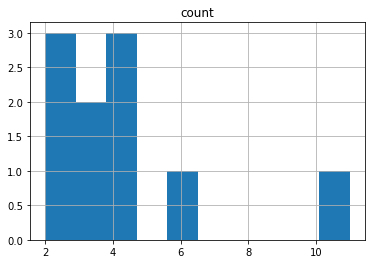

In [97]:
top_companies_p=top_companies.toPandas()
top_companies_p.hist('count')

[Text(0, 0, 'SEDO GmbH'),
 Text(1, 0, 'CLOUDFLARENET'),
 Text(2, 0, 'Hetzner Online GmbH'),
 Text(3, 0, 'netcup GmbH'),
 Text(4, 0, 'Strato AG'),
 Text(5, 0, 'Wix.com Ltd.'),
 Text(6, 0, 'Deutsche Telekom AG'),
 Text(7, 0, 'Team Internet AG'),
 Text(8, 0, '1&1 Ionos Se'),
 Text(9, 0, 'Neue Medien Muennich GmbH')]

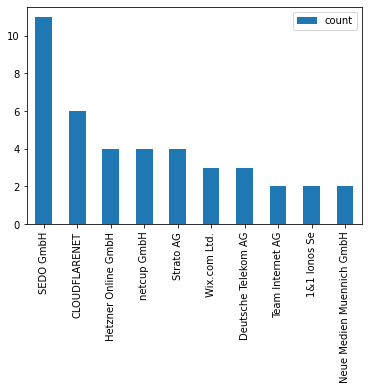

In [111]:
xlabels = top_companies.select("autonomous_system_organization").rdd.flatMap(list).collect()
top_companies_p.plot(kind='bar').set_xticklabels(xlabels)

## Where are these companys located?

In [106]:
top_locate=df_joint_all.join(top_companies,"autonomous_system_organization","right").select("autonomous_system_organization","country_name","count").distinct().sort(desc("count"))
top_locate.show()

+------------------------------+------------+-----+
|autonomous_system_organization|country_name|count|
+------------------------------+------------+-----+
|                     SEDO GmbH|        null|   11|
|                 CLOUDFLARENET|        null|    6|
|                     Strato AG|     Germany|    4|
|           Hetzner Online GmbH|     Germany|    4|
|                   netcup GmbH|     Germany|    4|
|                  Wix.com Ltd.|        null|    3|
|           Deutsche Telekom AG|        null|    3|
|                  1&1 Ionos Se|     Germany|    2|
|              Team Internet AG|     Germany|    2|
|          Neue Medien Muenn...|     Germany|    2|
+------------------------------+------------+-----+



In [ ]:
xlabels = top_locate.select("autonomous_system_organization").rdd.flatMap(list).collect()
top_companies_p.plot(kind='bar').set_xticklabels(xlabels)

## How many websites use Cloudflare?


In [91]:
dfJoinA.filter(dfJoinA.autonomous_system_organization=='CLOUDFLARENET').show()


+------------------+--------------------+--------------------+-----+-------------+-------------+------------------------+------------------------------+--------------+------------+
|  Top level domain|           MX-Record|            A-Record|pos_A|        val_A|      network|autonomous_system_number|autonomous_system_organization|network_adress|subnetzmaske|
+------------------+--------------------+--------------------+-----+-------------+-------------+------------------------+------------------------------+--------------+------------+
|         0-9a-z.de|"[""mail.0-9a-z.d...|[104.24.103.72,10...|    0|104.24.103.72|104.16.0.0/12|                   13335|                 CLOUDFLARENET|    104.16.0.0|          12|
|         0-9a-z.de|"[""mail.0-9a-z.d...|[104.24.103.72,10...|    1|104.24.102.72|104.16.0.0/12|                   13335|                 CLOUDFLARENET|    104.16.0.0|          12|
|0-euro-flatrate.de|                  []|[104.27.165.83,10...|    0|104.27.165.83|104.16.0.0/12

In [92]:
dfJoinA.filter(dfJoinA.autonomous_system_organization=='CLOUDFLARENET').count()


6

## How many German websites use German hosting providers?


In [93]:
df_joint_all.filter(df_joint_all.country_name=="Germany").count()

15

In [ ]:
dfJoinA.filter(dfJoinA.autonomous_system_organization.like('%Strato%')).show()
dfJoinA.filter(dfJoinA.autonomous_system_organization.like('%Strato%')).count()




In [ ]:
dfJoinA.filter(dfJoinA.autonomous_system_organization.like('%Hetzner%')).count()


In [ ]:
dfJoinA.filter(dfJoinA.autonomous_system_organization.like('%Mittwald%')).count()


Which email provider are used (MX record)?


In [ ]:
#Idee: Fehler 'DataFrame' object has no attribute 'MX'

#dfJoinA.filter(dfJoinA.MX-Record=='%de').count()
#dfJoinA.filter(dfJoinA.MX-Record=='%en').count()
